# **MOVIELENS RECOMMENDER SYSTEM**

## **1. Business Understanding**
------------------------------------

### 1.1: Problem Statement

In the modern streaming era, users are often overwhelmed by vast content libraries, leading to "choice paralysis" and platform abandonment. When users cannot quickly find content that aligns with their tastes, engagement drops and churn rates consequently increase.

### 1.2: Objective

The goal of this project is to build a Hybrid Recommendation System that leverages historical user data to provide personalized 'Top 5' movie recommendations. 
<br>
By automating content discovery, the system aims to:

  * Increase User Retention: Keep users on the platform longer by surfacing relevant content.

  * Enhance Experience: Reduce the cognitive load of searching for movies.

  * Optimize Engagement: Use predictive modeling (Collaborative Filtering) to identify high-interest items a user hasn't yet discovered.

### 1.3: Success Criteria

Success Criteria
The model will be considered successful if it achieves:

  - A low RMSE (Root Mean Squared Error), indicating high accuracy in predicting user ratings.

  - High Precision@k, ensuring that the top recommendations are truly relevant to the user.

## **2. Data Understanding**
------------------------------


### 2.1: Importing the necessary Libraries

In [101]:
# The necessary imports
import pandas as pd
import numpy as np

# Imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Content-Based Filtering Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

# Collaborative Filtering Preprocessing
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

### 2.2: Data Loading and Inspection

The dataset provides a rich snapshot of user-item interactions hence allowing for the development of both collaborative and content-based models.

**2.2.1: Dataset Composition**

This dataset comprises four interconnected files that map movie attributes to user behaviors and external metadata.

1. movies.csv - The primary catalog containing movieId, title (with release year) and a pipe-separated list of genres (e.g., Action|Sci-Fi).

In [102]:
movies = pd.read_csv('Datasets/Movielens_data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


2. ratings.csv: A collection of user-movie interactions featuring userId, movieId and a rating on a 5-star scale with 0.5-star increments.

In [103]:
ratings = pd.read_csv('Datasets/Movielens_data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


3. tags.csv: User-generated metadata providing short, descriptive phrases (e.g., "cult classic") for specific films. It includes userId, movieId and the tag content.

In [104]:
tags = pd.read_csv('Datasets/Movielens_data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


4. links.csv: A relational bridge containing movieId, imdbId and tmdbId to facilitate integration with external platforms like IMDb and The Movie Database.

In [105]:
links = pd.read_csv('Datasets/Movielens_data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


**2.2.2: Merging the Datasets**

By utilizing the `movieId` column as the primary key we joined the metadata from movies.csv and links.csv with the user-generated observations in ratings.csv and tags.csv.

In [106]:
df1 = pd.merge(movies, links, on='movieId', how='inner')
df1.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [107]:
df2 = pd.merge(df1, ratings, on='movieId', how='left')
df2.head()

,movieId,title,genres,imdbId,tmdbId,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,17.0,4.5,1.305696e+09


In [108]:
final_df = pd.merge(df2, tags, on=['userId', 'movieId'], 
                    how='left', suffixes=('_rating', '_tag'))
final_df.head()


,movieId,title,genres,imdbId,tmdbId,userId,rating,timestamp_rating,tag,timestamp_tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1.0,4.0,9.649827e+08,NaN,NaN
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,5.0,4.0,8.474350e+08,NaN,NaN
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,7.0,4.5,1.106636e+09,NaN,NaN
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,15.0,2.5,1.510578e+09,NaN,NaN
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,17.0,4.5,1.305696e+09,NaN,NaN


Now to save the data for subsequent analysis

In [109]:
final_df.to_csv('Datasets/merged_movie_data.csv', index=False)

## **3. Data Preparation**
----------------------------------------------------------

### **3.1: Exploratory Data Analysis**

   * **Distribution of Movie Ratings**
<br>

This shows that users mostly rate movies they enjoy.

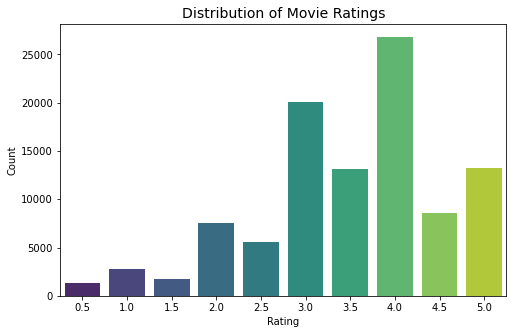

In [110]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Movie Ratings', fontsize=14)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

   * **Most rated movies (Top 10)**
<br>

We identified the movies that drive the most user interaction and consequently highlighting a "popularity bias" where a few well-known movies receive a disproportionately large number of ratings.

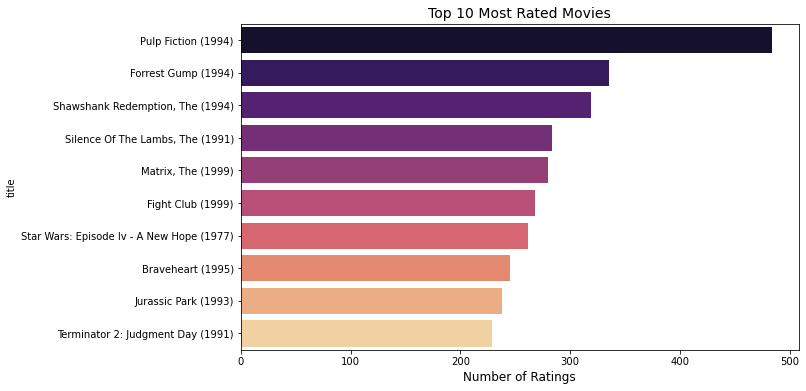

In [111]:
top_10_movies = data1.groupby('title').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='magma')
plt.title('Top 10 Most Rated Movies', fontsize=14)
plt.xlabel('Number of Ratings', fontsize=12)
plt.show()

  * **User activity(Ratings per user)**
<br>

This histogram of ratings per user shows that there are a few "power users" who rate hundreds of movies while a majority of "casual users" rate only a few.

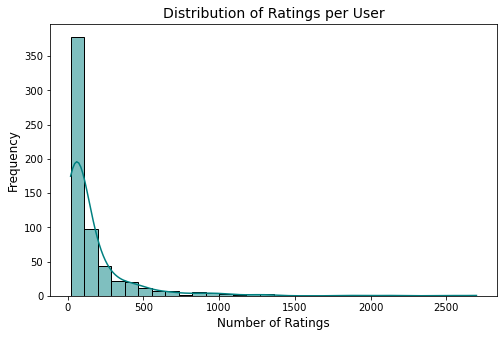

In [112]:
user_counts = ratings.groupby('userId').size()
plt.figure(figsize=(8, 5))
sns.histplot(user_counts, bins=30, kde=True, color='teal')
plt.title('Distribution of Ratings per User', fontsize=14)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


 * **The Long Tail: Number of Ratings per Movie**
<br>

This curve shows that a few movies get all the attention while most have almost none. This observation thus calls for a need to use SVD.

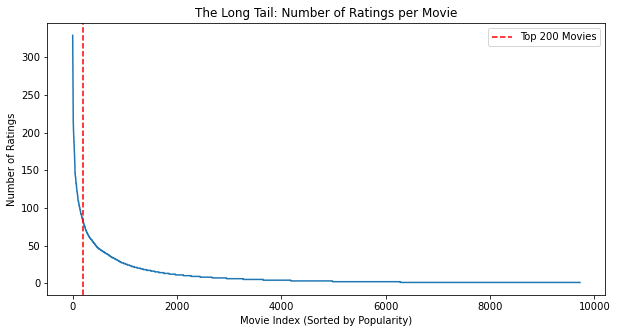

In [113]:
movie_counts = ratings.groupby('movieId').size().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
plt.plot(movie_counts.values)
plt.title('The Long Tail: Number of Ratings per Movie')
plt.xlabel('Movie Index (Sorted by Popularity)')
plt.ylabel('Number of Ratings')

# Shading the "Head" vs "Tail"
plt.axvline(x=200, color='red', linestyle='--', label='Top 200 Movies')
plt.legend()
plt.show()

### **3.2: Data Cleaning**

In [114]:
merged_data = pd.read_csv('Datasets/merged_movie_data.csv')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102695 entries, 0 to 102694
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieId           102695 non-null  int64  
 1   title             102695 non-null  object 
 2   genres            102695 non-null  object 
 3   imdbId            102695 non-null  int64  
 4   tmdbId            102682 non-null  float64
 5   userId            102677 non-null  float64
 6   rating            102677 non-null  float64
 7   timestamp_rating  102677 non-null  float64
 8   tag               3476 non-null    object 
 9   timestamp_tag     3476 non-null    float64
dtypes: float64(5), int64(2), object(3)
memory usage: 7.8+ MB


a. Checking for duplicates

In [115]:
merged_data.duplicated().sum()

0

b. Checking any missing values

In [116]:
merged_data.isnull().sum()

movieId                 0
title                   0
genres                  0
imdbId                  0
tmdbId                 13
userId                 18
rating                 18
timestamp_rating       18
tag                 99219
timestamp_tag       99219
dtype: int64

In [117]:
# Filling missing tags with a placeholder 
merged_data['tag'] = merged_data['tag'].fillna('no_tag')
merged_data['timestamp_tag'] = merged_data['timestamp_tag'].fillna(0)  # 0 will indicate no tag

# Dropping rows where there is no rating or userId 
merged_data.dropna(subset=['userId', 'rating'], inplace=True)

# Dropping the tmdbId missing values. They are only 13
merged_data.dropna(subset=['tmdbId'], inplace=True)

merged_data.isnull().sum()

movieId             0
title               0
genres              0
imdbId              0
tmdbId              0
userId              0
rating              0
timestamp_rating    0
tag                 0
timestamp_tag       0
dtype: int64

c. Standardizing the title column and extracting the year for a time series analysis

In [118]:
# Remove leading/trailing spaces and make titles title-case
merged_data['title'] = merged_data['title'].str.strip().str.title()

### **3.2: Feature Engineering**

___________________________
**Content-Based Filtering**
___________________________


There is need to expand the pipe-separated genres into individual columns (e.g., Action, Comedy). This will ensure the model treats "Action" as a distinct feature rather the entire long string.

In [119]:
# Creating dummy columns from the 'genres' string
genre_dummies = merged_data['genres'].str.get_dummies(sep='|')

# Joining the new dummy columns
data = pd.concat([merged_data, genre_dummies], axis=1)

# Dropping the original 'genres' column 
data = data.drop('genres', axis=1)

# Display the first few rows with the new genre columns
data.head(3)

,movieId,title,imdbId,tmdbId,userId,rating,timestamp_rating,tag,timestamp_tag,(no genres listed),...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),114709,862.0,1.0,4.0,9.649827e+08,no_tag,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story (1995),114709,862.0,5.0,4.0,8.474350e+08,no_tag,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story (1995),114709,862.0,7.0,4.5,1.106636e+09,no_tag,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# Creating a unique list of movies for content-based filtering
movies_unique = data.groupby('title').agg({
    'tag': lambda x: ' '.join(set(x.replace('no_tag', ''))),
    'movieId': 'first'
}).reset_index()

Applying TF-IDF to the `tag` column to transform the raw text of the tags into a meaningful numerical representation hence quantifying the importance of each tag for each movie.

In [121]:
# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Replacing 'no_tag' with an empty string 
tags_to_vectorize = data['tag'].replace('no_tag', '')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_unique['tag'])

Since this dataset is very large, calculating the entire similarity matrix at once is memory intensive hence we created similarity scores for one movie at a time against all others

In [122]:
# Create a mapping from movie titles to dataframe indices
indices = pd.Series(movies_unique.index, index=movies_unique['title']).drop_duplicates()

def get_recommendations(title, num_recommendations=10):
    if title not in indices:
        return f"Movie '{title}' not found in the database."
    
    # Getting the index of the movie that matches the title
    idx = indices[title]

    # Computing similarity scores for the given movie 'idx' against all others
    cosine_sim = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Indices of the top N most similar movies
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]

    # Getting the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_unique['title'].iloc[movie_indices]

In [123]:
# A sample recommendation
recommendations = get_recommendations('Toy Story (1995)')
recommendations

1446                Bug'S Life, A (1998)
3668    Guardians Of The Galaxy 2 (2017)
8867                  Toy Story 2 (1999)
1043                   Big Hero 6 (2014)
8524               The Lego Movie (2014)
689                 Avengers, The (2012)
9102                           Up (2009)
6861                 Pulp Fiction (1994)
0                             '71 (2014)
1                     'Burbs, The (1989)
Name: title, dtype: object

_________________________________________
**Collaborative Filtering Preprocessing**
_________________________________________

We then proceeded to Collaborative Filtering Preprocessing so as to find users with similar taste patterns. We chose SVD to handle the data since it handles sparsity very effectively. 

In [124]:
# Defining the Reader and load into Surprise format
reader = Reader(rating_scale=(1, 5)) 
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split into Train and Test samples
trainset, testset = train_test_split(data, test_size=0.20)

# Initialize the SVD Model
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

print(f"Model Accuracy (RMSE): {accuracy.rmse(predictions)}")

RMSE: 0.8733
Model Accuracy (RMSE): 0.8732525709634827


In [125]:
# Predict a rating for a specific User and Movie; rating for User 15 on Movie 55
pred = algorithm.predict(15, 55) 
print(f"Predicted Rating for User {pred.uid} on Movie {pred.iid}: {pred.est:.2f}")

Predicted Rating for User 15 on Movie 55: 3.30


**Hyperparameter tuning**
_________________________

In [ ]:
# Defining the parameter grid
param_grid = {
    'n_factors': [50, 100, 150], # The number of latent factors (dimensionality of user/item vectors)
    'n_epochs': [20, 30], # The number of iterations of the SGD procedure
    'lr_all': [0.002, 0.005, 0.01], # The learning rate for all parameters
    'reg_all': [0.02, 0.1, 0.4]  # The regularization term for all parameters to prevent overfitting
}

# Initializing GridSearchCV
gridSearch = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the grid search 
gridSearch.fit(data)
print(f"Best RMSE score: {gridSearch.best_score['rmse']}")
print(f"Best parameters: {gridSearch.best_params['rmse']}")

# Using the best parameters to build the final model
best_algo = gridSearch.best_estimator['rmse']
trainset = data.build_full_trainset()
best_algo.fit(trainset)

# Test a prediction with the optimized model
uid = 1  
iid = 55 
pred = best_algo.predict(uid, iid)
print(f"Optimized Predicted Rating for User {uid} on Movie {iid}: {pred.est:.2f}")

Best RMSE score: 0.8614702631356564
Best parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
Optimized Predicted Rating for User 1 on Movie 55: 4.50


2.2 Statistical Challenges & Constraints
To build a "best-in-class" system, we must account for the following data characteristics:

Matrix Sparsity: With 943 users and 1,682 movies, the interaction matrix has a density of only 6.3%. Most users have only rated a fraction of the library. Our model (SVD) must be robust enough to "fill in the gaps" via latent factor estimation.

The Long Tail Distribution: A small percentage of movies (popular blockbusters) receive the vast majority of ratings. Conversely, a large "tail" of movies has very few ratings, which can lead to biased recommendations if not handled during the data preprocessing stage.

Rating Bias: Users typically provide ratings for movies they have already chosen to watch, creating a "selection bias." We will examine the mean rating distribution to determine if the baseline is skewed toward higher scores (e.g., a mean of 3.5 instead of 2.5).

## **4. Modelling**
----------------------------------------------------------

Given that the two filtering models are created, we decided to  build a Hybrid Recommendation System where we combine the Content-Based Filtering with the Collaborative Filtering.

This approach also addresses the "Cold Start" problem by using genres/tags for new items while using SVD to provide high-accuracy personalized ratings for established users.

In [129]:
def hybrid_recommendations(user_id, movie_title, num_recommendations=5):
    # The initial candidates using Content-Based Filtering
    content_sim_movies = get_recommendations(movie_title, num_recommendations=20)
    
    # Extracting Movie IDs for these candidates
    candidate_ids = movies_unique[movies_unique['title'].isin(content_sim_movies)]['movieId'].tolist()
    
    # Using the tuned SVD model to predict ratings for this specific user
    predictions = []
    for m_id in candidate_ids:
        pred = best_algo.predict(user_id, m_id)
        predictions.append((m_id, pred.est))
    
    # Sorting candidates by their predicted SVD rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Getting titles for the top N candidates
    top_movie_ids = [p[0] for p in predictions[:num_recommendations]]
    top_titles = movies_unique[movies_unique['movieId'].isin(top_movie_ids)]['title']
    
    return top_titles

In [134]:
# Testing the hybrid recommendation system
hybrid_recommendations(user_id=555555, movie_title='Toy Story (1995)')

689                 Avengers, The (2012)
3668    Guardians Of The Galaxy 2 (2017)
6861                 Pulp Fiction (1994)
8867                  Toy Story 2 (1999)
9102                           Up (2009)
Name: title, dtype: object

### **4.1: Evaluation metrics**